# important links


## list:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels?sortBy=voteCount&group=everyone&pageSize=20&language=Python&competitionId=5407


## xgboost:
https://www.kaggle.com/dansbecker/xgboost

https://medium.com/@gabrieltseng/gradient-boosting-and-xgboost-c306c1bcfaf5



## regration + graph :
https://www.kaggle.com/janiobachmann/predicting-house-prices-regression-techniques


## Selecting and Filtering Data
https://www.kaggle.com/dansbecker/selecting-and-filtering-in-pandas

## Handling Missing Values
https://www.kaggle.com/dansbecker/handling-missing-values



## why use conditional probability coding
https://medium.com/airbnb-engineering/designing-machine-learning-models-7d0048249e69

## one hot encoding
https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f


# Imports:

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  r2_score
from sklearn.preprocessing import normalize,MinMaxScaler

# Data Management

### Load Data

In [2]:
train = pd.read_csv('train.csv').select_dtypes(exclude=['object'])
test = pd.read_csv('test.csv').select_dtypes(exclude=['object'])

#look into datatypes of the file
print("data types count")
train.dtypes.groupby(train.dtypes).count()


data types count


int64      35
float64     3
dtype: int64

In [3]:
#selecting target
train_target = train.SalePrice
#the last column is the SalePrice coloumn so removing it from the list
predictor_cols = train.drop(train.columns[-1],axis=1)
# droping id
predictor_cols = predictor_cols.drop('Id',axis=1)
predictor_cols_test = test.drop('Id',axis=1)


### Looking into data

In [4]:
print('show sample')
train.head()

show sample


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [5]:
print('description of data')
train.describe()

description of data


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Removing missing data

In [6]:
missing_data_col = train.isnull().sum()
missing_data_col.plot.bar(title = 'missing data before')
total_row = train.index.size
missing_data_list = missing_data_col[missing_data_col > total_row*.50].index
train = train.drop(missing_data_list,1)
# removing form kaggle test data also
test = test.drop(missing_data_list,1)

### Imputing missing data
    We are using simpleimputer and it uses mean by default. It will just replace those empty places with mean values.
    In this section we are impute missing coloumn where the missing data amount is less than 50%. 

In [7]:
def imputation(predictor_cols):
    imputer_numb_col = SimpleImputer(strategy="most_frequent" , missing_values=np.nan )
    imputer_obj_col = SimpleImputer(strategy="most_frequent" , missing_values=np.nan )
    #excluding all object dtype column
    train_num_col = predictor_cols.select_dtypes(exclude= ['object'])
    #excluding all number dtype column
    train_obj_col = predictor_cols.select_dtypes(include=['object'])
    
    """ 
    fit_transform turns a df to numpy array so keeping the column name would be helpful for returning to df format
    """
    
    #imputing number part of df
    column_names = train_num_col.columns.values
    train_num_col = imputer_numb_col.fit_transform(train_num_col)
    # putting imputed values in the place of missing values of original detaframe 
    train_num_col = pd.DataFrame(train_num_col, columns = column_names)
    return train_num_col
    """
    # imputing object part of df
    column_names = train_obj_col.columns.values
    train_obj_col = imputer_obj_col.fit_transform(train_obj_col)   
    train_obj_col = pd.DataFrame(train_obj_col,columns = column_names)
    
    #One hot encoding
    
    #combinin numb and obje part to predictor_cols
    predictor_cols = train_num_col.combine_first(train_obj_col)
    return predictor_cols
    """

In [8]:


predictor_cols = imputation(predictor_cols)
#imputing for kaggles test data
predictor_cols_test = imputation(predictor_cols_test)

### after imputation graphs

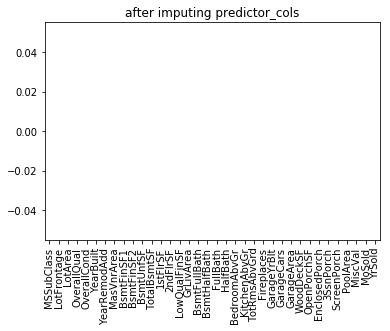

In [9]:
pd.DataFrame(predictor_cols).isnull().sum().plot.bar(title = "after imputing predictor_cols")

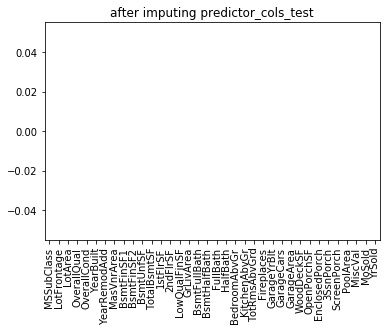

In [10]:
pd.DataFrame(predictor_cols_test).isnull().sum().plot.bar(title = "after imputing predictor_cols_test")

### One hot encoding
To encode categorical integer features as a one-hot numeric array we are using one hot encoding. This will transform each value of catagories into a features and make those a column value of dataframe. Finally put binary values in the rows of those column.

In [11]:
# for example:

# ╔════════════╦═════════════════╦════════╗ 
# ║ CompanyName Categoricalvalue ║ Price  ║
# ╠════════════╬═════════════════╣════════║ 
# ║ VW         ╬      1          ║ 20000  ║
# ║ Acura      ╬      2          ║ 10011  ║
# ║ Honda      ╬      3          ║ 50000  ║
# ║ Honda      ╬      3          ║ 10000  ║
# ╚════════════╩═════════════════╩════════╝

# converting it to one Hot encoding:

# ╔════╦══════╦══════╦════════╦
# ║ VW ║ Acura║ Honda║ Price  ║
# ╠════╬══════╬══════╬════════╬
# ║ 1  ╬ 0    ╬ 0    ║ 20000  ║
# ║ 0  ╬ 1    ╬ 0    ║ 10011  ║
# ║ 0  ╬ 0    ╬ 1    ║ 50000  ║
# ║ 0  ╬ 0    ╬ 1    ║ 10000  ║
# ╚════╩══════╩══════╩════════╝

# refrence: https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

In this section at first we merge train and test data (variable name predictor_cols and predictor_cols_test). We did it because there is some fetures in train data which is missing in test data again same thing can happen for test data too. 

In [12]:
# enc = OneHotEncoder(handle_unknown='ignore')
# # getting last index of training data
# lenth_predictor_cols = len(predictor_cols)
# #performing one hot encoding on all data
# all_data = predictor_cols.append(predictor_cols_test, ignore_index=True)
# all_data = enc.fit_transform(all_data)
# # all_data is no in scipy.sparse.csr.csr_matrix format converting it to 2d-numpy array
# all_data = all_data.toarray()
# # seperate the dataset again after performing one hot encoding
# # nd array works diffrently than pandas df.loc[] 
# predictor_cols = all_data[:lenth_predictor_cols]
# predictor_cols_test = all_data[lenth_predictor_cols:]


### Split Data for training and testing

In [13]:
X_train, X_test, y_train, y_test = train_test_split(predictor_cols, 
                                                    train_target,
                                                    train_size=0.8, 
                                                    test_size=0.2, 
                                                    random_state=1)

# Model selection

## Model selection

### Linear Regression

In [14]:

# Parameters
learning_rate = 0.01
# num_steps = 500

hidden_1 = 256
hidden_2 = 256
hidden_3 = 64

input_dim = X_train.shape[1]  # Number of features
output_dim = 1              # Because it is a regression problem
#tf graph input
X_tf = tf.placeholder("float" )
y_tf = tf.placeholder("float" )

In [15]:

weights = {
    'w1': tf.Variable(tf.random_normal([input_dim, hidden_1])),
    'w2': tf.Variable(tf.random_normal([hidden_1, hidden_2])),
    'w3': tf.Variable(tf.random_normal([hidden_2, hidden_3])),
    'out': tf.Variable(tf.random_normal([hidden_3, output_dim]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([hidden_1])),
    'b2': tf.Variable(tf.random_normal([hidden_2])),
    'b3': tf.Variable(tf.random_normal([hidden_3])),
    'out': tf.Variable(tf.random_normal([output_dim]))
}

In [16]:
# Model Design

def ann_model(X_val):
  # Hidden layers
  layer_1 = tf.add(tf.matmul(X_val, weights['w1']), biases['b1'])
  layer_1 = tf.nn.relu(layer_1)
  
  layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
  layer_2 = tf.nn.relu(layer_2)
  
  layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
  layer_3 = tf.nn.relu(layer_3)
  
  # Output layer
  layer_out = tf.add(tf.matmul(layer_3, weights['out']), biases['out'])
  
  return layer_out

In [17]:


# Model Construct
model = ann_model(X_tf)

# Mean Squared Error cost function
cost = tf.reduce_mean(tf.square(y_tf - model))


# Adam optimizer will update weights and biases after each step
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model (with test logits, for dropout to be disabled)
# correct_pred = tf.equal(tf.argmax(model, 1), tf.argmax(y_tf, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize variables 
init = tf.global_variables_initializer()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

In [18]:

with tf.Session() as sess:
    #running initializer
    sess.run(init)
    for i in range(1000):
        sess.run(optimizer, feed_dict={X_tf:X_train, y_tf:y_train})
        if (i+1)%100 == 0:
            print("batch no : ",i+1)
            
    # Save the variables to disk.
    save_path = saver.save(sess, "/tmp/model.ckpt")
    print("Model saved in path: %s" % save_path)
    
    pred = sess.run(model, feed_dict={X_tf: X_test})
    prediction = pred.squeeze()
#     print()
#     print(pred)
    
#   pred = np.expm1(pred)
#   print(pred)

print('mean absolute error: ',mean_absolute_error(y_test.values, prediction))
print('accuracy score: ',  r2_score(np.array(y_test),prediction) )


batch no :  100
batch no :  200
batch no :  300
batch no :  400
batch no :  500
batch no :  600
batch no :  700
batch no :  800
batch no :  900
batch no :  1000
Model saved in path: /tmp/model.ckpt
mean absolute error:  59934.56870719178
accuracy score:  0.009811128798827062


In [19]:
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/model.ckpt")
    print("Model restored.")
    
    # Check the values of the variables
    pred =  sess.run(model, feed_dict={X_tf: predictor_cols_test})
    prediction = pred.squeeze()
    print(prediction)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
Model restored.
[180238.47 171541.4  184452.95 ... 179801.55 186821.6  184042.02]


In [20]:
my_model = LinearRegression()

### Random Forest Regressor

In [21]:

#my_model = RandomForestRegressor()

### DecisionTree

In [22]:
# from sklearn.tree import DecisionTreeRegressor
# my_model = DecisionTreeRegressor()

### k-nearest neighbors 

In [23]:
# from sklearn.neighbors import KNeighborsClassifier
# my_model = KNeighborsClassifier(n_neighbors=5)

## Model fit on training set

In [24]:
my_model.fit(X_train, y_train)
prediction = my_model.predict(X_test)

## Model fit for test set

In [25]:
prediction_test = my_model.predict(predictor_cols_test)

# Acuracy Score

In [26]:
print('mean absolute error: ',mean_absolute_error(y_test, prediction))
print('accuracy score: ', my_model.score(X_test,y_test))

mean absolute error:  21750.746114635866
accuracy score:  0.8172321867438745


In addition to your training data, there will be test data. This is frequently stored in a file with the title `test.csv`. This data won't include a column with your target (y), because that is what we'll have to predict and submit.  Here is sample code to do that. 

# Prepare Submission File
We make submissions in CSV files.  Your submissions usually have two columns: an ID column and a prediction column.  The ID field comes from the test data (keeping whatever name the ID field had in that data, which for the housing data is the string 'Id'). The prediction column will use the name of the target field.

We will create a DataFrame with this data, and then use the dataframe's `to_csv` method to write our submission file.  Explicitly include the argument `index=False` to prevent pandas from adding another column in our csv file.

In [27]:

my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': prediction_test})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)